**CS 481 Final Project**

The goal of this project is to classify tweets from members of U.S. congress by their political party. 

The file ['party_tweets.csv'](https://github.com/GeorgeIIT/cs481project/blob/main/party_tweets.csv) contains tweets and retweets from members of the US Congress. Each tweet is labeled with the congress member's party affiliation. The partys are Democrats and Republicans, Members of a third party were not included. Tweets were collected by pulling the last 40 tweets (retweets included) from each congress member's user timeline on 4/1/21. The goal for this repository is to predict the political party of a legislator based on the content they share online. It should be noted that these are official twitter accounts so the vast majority of the content posted is relevant to the user's political career. Models trained with this dataset may not be effective for predicting the party affiliation of non-political content, or political content from perspectives outside of the United States.

  * Total tweets: 21181
  * Democrat Tweets (D): 10956
  * Republican Tweets (R): 10225
  * Ratio: 52:48 D:R

The code used for collecting the twitter data is in ['Get_congress_tw_data.py'](https://github.com/GeorgeIIT/cs481project/blob/main/Get_congress_tw_data.py). If you wish to run it, you will need to provide your own twitter authentication tokens. Also be warned that it takes several hours to run because of the rate limit for twitter API calls.

Congress member twitter handles were found on [Triage Cancer's](https://triagecancer.org/congressional-social-media) website.

**Libraries Used**

In [3]:
#Data Representation
import numpy as np
import pandas as pd
import string

#Preprocessing Text
from tqdm import tqdm
import re
from bs4 import BeautifulSoup

#Vector Representaion
from sklearn.feature_extraction.text import CountVectorizer

#Train/Test Split
from sklearn.model_selection import train_test_split

#Logistic Regression Algorithm
from sklearn.linear_model import LogisticRegression

#Performance Evaluation
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

#Parameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#Plotting (used to explore the data and evaluate model performance)
import matplotlib.pyplot as plt

**Load the Data**

In [40]:
#read in the data as a pandas dataframe, pipes (|) were used as delimiters. 
data = pd.read_csv('party_tweets.csv',sep='|',engine='python',encoding='utf-8',quoting=3)
#make sure pandas does not truncate display
pd.set_option('display.max_colwidth', -1) #change '-1' to 'none' here if using a later version of pandas 
data.shape, display(data.head())

,idx,tweet,party
0,0,"Happy birthday, @SenatorLeahy. Grateful for our longstanding friendship and willingness to work together on the Senate Appropriations Committee. Looking forward to another productive year.",R
1,1,Pleased that 20 airports throughout Alabama will benefit from more than $11.2M in @FAAnews grants. These @USDOT funds will help airports receive the upgrades and enhancements needed to continue serving local communities and driving economic development. <webLink>,R
2,2,More information regarding my letter: <webLink>,R
3,3,"Today I sent a letter to @Amtrak, @CSX, @nscorp, & Surface Transportation Board stating that a data-driven process is essential prior to starting new passenger rail in Mobile. A comprehensive study would alleviate concerns re how the new service could impact growth in the area. <webLink>",R
4,4,🚨LIVE NOW🚨Senate GOP is on the ground discussing the crisis at the border.Tune in here! ⤵️ <webLink>,R


((21182, 3), None)

**Exploring the Data**

empty cells:
idx      0
tweet    0
party    0
dtype: int64

Shape before dropping duplicates:
(21182, 3)
Shape after dropping duplicates:
(21171, 3)

Distribution of classes:
D    10956
R    10215
Name: party, dtype: int64

Tweet charechter length info:
count    21171.000000
mean     199.848425  
std      74.182438   
min      3.000000    
25%      148.000000  
50%      220.000000  
75%      262.000000  
max      735.000000  
Name: length, dtype: float64


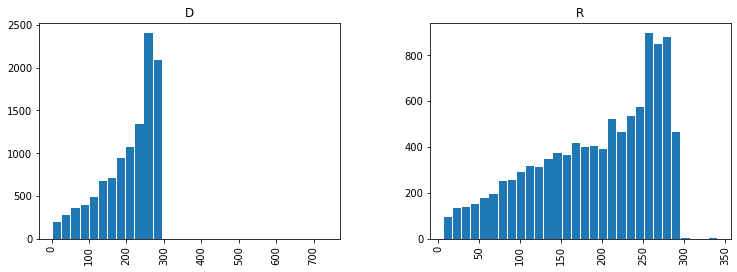

,tweet,party,length
3037,"@LisaBRochester @AnnMcLaneKuster @CarolynBMaloney @val_demings @wildforcongress @StricklandforWA @SpanbergerVA07 @KatherineClark @AlmaforCongress @Lizzie4Congress @LindaTSanchez @JoyceBeatty @LoisFrankel @dinatitus @lucymcbath @DeborahRossNC @JackieSpeier @AOC @RobinLynneKelly @SMurphyCongress @ElaineLuriaVA @RepSchakowsky @Marcy_Kaptur @LaurenUnderwood @ElissaSlotkin @Matsui4Congress @vgescobar @AyannaPressley @Axne4Congress @Bonnie4Congress Congresswoman @KathyManningNC worked as a nonprofit leader, helping to create opportunity for #NC06 families with equity in education and health care.As a small business owner, she developed a passion for an economy that truly rewards hard work & innovation. #WomensHistoryMonth <webLink>",D,735


In [41]:
#check empty cells (should be 0 for this dataset)
print("empty cells:\n{}".format(data.isnull().sum()))

#drop duplicate entries, this data set happens to have 10
print("\nShape before dropping duplicates:\n{}".format(data.shape))
data = data.drop_duplicates(keep="first")
print("Shape after dropping duplicates:\n{}".format(data.shape))

#dropping the index given in the .csv file so it is not confused wit hthe pandas index 
data = data.drop(['idx'],axis=1)

#data is sorted by legislator in 40 tweet chunks, we need to shuffle them and reset the index
data = data.sample(frac=1, random_state=13).reset_index(drop=True)

#check the balance of the data
print("\nDistribution of classes:\n{}".format(data.party.value_counts()))

#take a look at the length of the tweets, this also adds a new column to the dataset
data['length'] = data['tweet'].apply(len)
print("\nTweet charechter length info:\n{}".format(data['length'].describe()))

#get a visualization of the length distribution by party
data.hist(column='length',by='party',bins=30,figsize=(12,4),rwidth=0.9)
plt.show()

#lets see a tweet that was over 280 chars
data.query('length > 700')

You can see above that most tweets max out at 280 charecters, Twitter's current charecter limit. There are a few outliers that changed the scale of the two graphs though. These posts were able to excceed the limit becuase mentions of other users do not count towards the charechter limit. Chains of mentions can create very long tweets like this.

**Preprocessing the Data**

These three functions are going to be used to clean up the data. Mainly expanding contractions and removing special charecters. But the last one converts the party label from D and R to 0 and 1 respectively. 

In [77]:
def decontracted(phrase):
    """
    We first define a function to expand the contracted phrase into normal words
    """
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase) # prime 
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase
def clean_text(df):
    """
    Clean the review texts
    """
    cleaned_review = []
    
    for tweet_text in tqdm(df['tweet']):
        
        #remove twitter handles
        #tweet_text = re.sub(r'@\S+',"", tweet_text)
        
        #remove hashtags
        #tweet_text = re.sub(r'#\S+',"", tweet_text)
        
        # expand the contracted words
        tweet_text = decontracted(tweet_text)
        
        #remove html tags
        tweet_text = BeautifulSoup(tweet_text, 'lxml').get_text().strip() # re.sub(r'<.*?>', '', text)
        
        #remove non-alphabetic characters
        tweet_text = re.sub("[^a-zA-Z]"," ", tweet_text)
    
        #the urls from tweets were replaced with '<weblink>', get rid of them here
        tweet_text = tweet_text.replace('<weblink>', '')
        
        #removing punctutation, string.punctuation in python consists of !"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`
        tweet_text = tweet_text.translate(str.maketrans('', '', string.punctuation))
        # ''.join([char for char in movie_text_data if char not in string.punctuation])
        
        #remove emails
        tweet_text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", '', tweet_text)
        
        cleaned_review.append(tweet_text)

    return cleaned_review

def convert_party_to_number(df):
    converted_label = []
    for numeric_party in df['party']:
        if(numeric_party == 'D'):
            numeric_party = 0
        else:
            numeric_party = 1
        converted_label.append(numeric_party)
    return converted_label

In [78]:
data['cleaned_tweet'] = clean_text(data)
data['numeric_party'] = convert_party_to_number(data)

100%|██████████████████████████████████████████████████████████████████████████| 21171/21171 [00:12<00:00, 1662.19it/s]



Tweet charechter length info:
count    21171.000000
mean     191.794625  
std      74.451879   
min      0.000000    
25%      140.000000  
50%      212.000000  
75%      253.000000  
max      725.000000  
Name: clean_length, dtype: float64


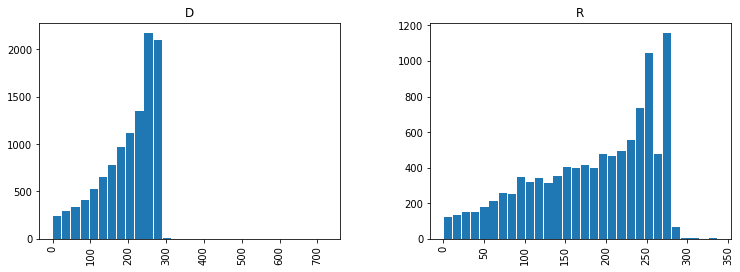

In [79]:
#take a look at the length of the cleaned tweets, this also adds a new column to the dataset
data['clean_length'] = data['cleaned_tweet'].apply(len)
print("\nTweet charechter length info:\n{}".format(data['clean_length'].describe()))

#get a visualization of the length distribution by party
data.hist(column='clean_length',by='party',bins=30,figsize=(12,4),rwidth=0.9)
plt.show()

Data after cleaning

In [80]:
data.query('clean_length == 285')
#data.shape, display(data.head())

,tweet,party,length,cleaned_tweet,numeric_party,clean_length
3676,"We've all gone through a lot in the past year. From one neighbor lost to now over 23k. We've seen families stretched, businesses close, and communities feel the pain. I voted for this bill because your government should be doing everything to help; it's why I voted to deliver it.",D,280,We have all gone through a lot in the past year From one neighbor lost to now over k We have seen families stretched businesses close and communities feel the pain I voted for this bill because your government should be doing everything to help it is why I voted to deliver it,0,285
5882,"@dr_sheffield And finally, question for ya...are the 70% of the HD 59 folks that went to the polls and voted to fire you in Mar all ET clones? Has NOTHING to do with ET & everything to do with yer awful liberal voting record & disdain/arrogance you’ve shown for your own constituents.",R,285,dr sheffield And finally question for ya are the of the HD folks that went to the polls and voted to fire you in Mar all ET clones Has NOTHING to do with ET everything to do with yer awful liberal voting record disdain arrogance you ve shown for your own constituents,1,285
6241,"@ruthiepang @CoCoHealth Hi @Ruthiepang, people currently eligible for appointments in Contra Costa include:•Anyone who is 50 or older and lives or works in the county•Anyone who is 16 or older and has a high-risk health condition, disability or illness and lives or works in the county &",D,287,ruthiepang CoCoHealth Hi Ruthiepang people currently eligible for appointments in Contra Costa include Anyone who is or older and lives or works in the county Anyone who is or older and has a high risk health condition disability or illness and lives or works in the county,0,285
6997,"@luke_mo_ Most of the children were with people that were not relatives. They were being smuggled for forced sex, labor, and other despicable things. There is human trafficking in/thru Arkansas, and more specifically, Northeast AR. They are coming from many Central American countries.",R,285,luke mo Most of the children were with people that were not relatives They were being smuggled for forced sex labor and other despicable things There is human trafficking in thru Arkansas and more specifically Northeast AR They are coming from many Central American countries,1,285
15034,"Today, @HouseDemocrats conducted official business without a quorum- the minimum # of members required. That's unconstitutional. That's why @HouseGOP, @FreedomCaucus led a lawsuit against proxy voting. We won't stop fighting @speakerpelosi & Dems eroding the Constitution & rules.",R,280,Today HouseDemocrats conducted official business without a quorum the minimum of members required That is unconstitutional That is why HouseGOP FreedomCaucus led a lawsuit against proxy voting We will not stop fighting speakerpelosi Dems eroding the Constitution rules,1,285
15074,@dr_sheffield More lies from the most liberal Republican in Texas. Empower isn’t in this race. Total dollars they’ve donated to me in last 5 yrs? Zero! Stop pointing to them as some bodice man trying to distract voters from yer collaboration with the socialists for the last 7 yrs.,R,285,dr sheffield More lies from the most liberal Republican in Texas Empower isn t in this race Total dollars they ve donated to me in last yrs Zero Stop pointing to them as some bodice man trying to distract voters from yer collaboration with the socialists for the last yrs,1,285
19650,"As Chairman of @SVACDems, I'm committed to ensuring we're living up to the promises we've made to our veterans. Today—and everyday—we honor the service and sacrifices of Vietnam vets across our nation, and reaffirm our commitment to ensuring they receive the care they've earned. <webLink>",D,289,As Chairman of SVACDems I am committed to ensuring we are living up to the promises we have made to our veterans Today and everyday we honor the service and sacrifices of Vietnam vet

Some of these tweets still go passed the charecter limit after cleaning them up. This time it's becuase the ``decontracted(phrase)`` function expands some words. Above you can see how this tweet was 280 before cleaning, but decontracting lead to a net gain in 5 characters.

**Vectorizing The Data**

Below is the set of stopwords that will be ignored by the count vectorizer. 

In [81]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't","no","nor","not"])

In [82]:
vectorizer = CountVectorizer(lowercase=True,stop_words=stopwords,max_df=0.6,min_df=1,ngram_range=(1,2))
#convert the celaned tweets into vectors, store them in X. Party labels stored in Y
X = vectorizer.fit_transform(data['cleaned_tweet'])
Y = data['numeric_party']
#print(X.toarray()[0])
print("Vector Shape:\t\t", X.shape)
print("Party Label Shape:\t", Y.shape)

Vector Shape:		 (21171, 251318)
Party Label Shape:	 (21171,)


**Train Test Split** 

Here I used an 80% training and 20% testing split to partition the data. 

In [83]:
train_idx, test_idx = train_test_split(np.arange(data.shape[0]), test_size=0.25, shuffle=True, random_state=42)

#show split
print("Number of training examples:\t", len(train_idx))
print("Number of testing examples:\t", len(test_idx))

#train/test split the data
X_train = X[train_idx]
Y_train = Y[train_idx]
X_test = X[test_idx]
Y_test = Y[test_idx]

#show shape of each partition
print("\nTraining data:\nX: {}, Y: {}".format(X_train.shape,Y_train.shape))
print("\nTesting data:\nX: {}, Y: {}".format(X_test.shape,Y_test.shape))

Number of training examples:	 15878
Number of testing examples:	 5293

Training data:
X: (15878, 251318), Y: (15878,)

Testing data:
X: (5293, 251318), Y: (5293,)


**Fitting the Logistic Regreassion**

In [84]:
#fit the logistic regression
lr_clf = LogisticRegression(max_iter=1000,solver='lbfgs',penalty='l2')
lr_clf.fit(X_train, Y_train)
y_pred_test = lr_clf.predict(X_test)
y_predprob_test = lr_clf.predict_proba(X_test)

**Evaluating Performance**

First looking at the classification report for logistic regression

In [86]:
#check out how well the model performed
print("Classification Report:\n", classification_report(Y_test, y_pred_test))
scores = cross_val_score(lr_clf, X, Y, cv=4, scoring='f1')
print("Cross Validation Score:\n",scores)

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82      2804
           1       0.79      0.83      0.81      2489

    accuracy                           0.81      5293
   macro avg       0.81      0.81      0.81      5293
weighted avg       0.81      0.81      0.81      5293

Cross Validation Score:
 [0.81239176 0.81959565 0.819151   0.81365135]


Now the ROC curve

Note that republicans were chosen as the "positive" label. This was an arbitrary decision following the labels 0 and 1 for D and R.  

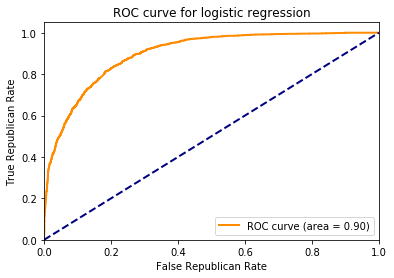

In [88]:
fpr, tpr, thresholds = roc_curve(y_true = Y_test, y_score = y_predprob_test[:,1], pos_label=1)
roc_auc = auc(fpr, tpr) # area under ROC curve

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Republican Rate')
plt.ylabel('True Republican Rate')
plt.title('ROC curve for logistic regression')
plt.legend(loc="lower right")
plt.show()

**Parameter Tuning with Grid Search**

In [55]:
vectorizer = CountVectorizer(lowercase=True,stop_words=stopwords)
logistic = LogisticRegression(max_iter=1000,solver='lbfgs')

#build a pipeline
pipe = Pipeline(steps = [('vectorizer',vectorizer),
                         ('classifier',logistic)])

#dictionary for model params and corresponding values
param_grid = {
    'vectorizer__min_df':[1,2,3],
    'vectorizer__max_df':[0.6,0.7,0.8],
    'vectorizer__ngram_range':[(1,1),(1,2),(2,2),(1,3)],
    'classifier__penalty':['none','l2']
}

search_result = GridSearchCV(pipe,param_grid,cv=4,scoring='f1',n_jobs=6).fit(data.cleaned_tweet.values, data.numeric_party.values)

print("Best parameter (CV score = %0.3f):" % search_result.best_score_)
print(search_result.best_params_)

Best parameter (CV score = 0.788):
{'classifier__penalty': 'l2', 'vectorizer__max_df': 0.6, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2)}


Top features for each party

In [91]:
feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(vectorizer.get_feature_names(), lr_clf.coef_[0])}

print("\nTop party 0 features:")
for item in (sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:15]):
    print(item)
    
print("\nTop party 1 features:")
for item in (sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:15]):
    print(item)


Top party 1 features:
('bidenbordercrisis', 2.2)
('realdonaldtrump', 2.105)
('democrats', 1.816)
('border', 1.741)
('china', 1.671)
('oklahoma', 1.455)
('ccp', 1.419)
('idaho', 1.334)
('get vote', 1.327)
('partisan', 1.305)
('spending', 1.304)
('utpol', 1.297)
('ohio', 1.295)
('god', 1.289)
('pelosi', 1.283)

Top party 0 features:
('americanrescueplan', -3.419)
('stopasianhate', -2.069)
('az', -1.681)
('democracy', -1.606)
('buildbackbetter', -1.599)
('guam', -1.456)
('msnbc', -1.453)
('forthepeople', -1.353)
('dcstatehood', -1.346)
('black', -1.337)
('american rescue', -1.33)
('transgender', -1.302)
('rescue plan', -1.295)
('chair', -1.289)
('sameach happy', -1.213)


**Fitting the Naive Bayes**

In [85]:
from sklearn.naive_bayes import BernoulliNB
nb_clf = BernoulliNB()
nb_clf.fit(X_train,Y_train)
nb_y_pred_test = nb_clf.predict(X_test)
nb_y_predprob = nb_clf.predict_proba(X_test)

classification report for naive bayes

In [87]:
#check out how well the model performed
print("Classification Report:\n", classification_report(Y_test, nb_y_pred_test))
scores = cross_val_score(nb_clf, X, Y, cv=4, scoring='f1')
print("Cross Validation Score:\n",scores)

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      2804
           1       0.81      0.83      0.82      2489

    accuracy                           0.83      5293
   macro avg       0.83      0.83      0.83      5293
weighted avg       0.83      0.83      0.83      5293

Cross Validation Score:
 [0.82071248 0.82850955 0.82343658 0.8171451 ]


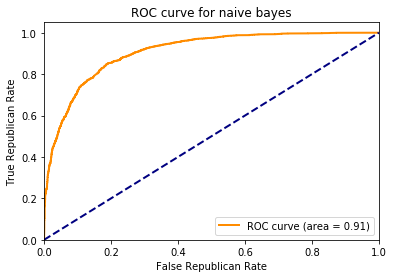

In [89]:
fpr, tpr, thresholds = roc_curve(y_true = Y_test, y_score = nb_y_predprob[:,1], pos_label=1)
roc_auc = auc(fpr, tpr) # area under ROC curve

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Republican Rate')
plt.ylabel('True Republican Rate')
plt.title('ROC curve for naive bayes')
plt.legend(loc="lower right")
plt.show()

In [98]:
nb_feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(vectorizer.get_feature_names(), nb_clf.feature_log_prob_[0,:])}

print("\nTop party 0 features:")
for item in (sorted(nb_feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:15]):
    print(item)
    
nb_feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(vectorizer.get_feature_names(), nb_clf.feature_log_prob_[1,:])}

print("\nTop party 1 features:")
for item in (sorted(nb_feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:15]):
    print(item)
    


Top party 0 features:
('today', -1.956)
('covid', -2.248)
('act', -2.419)
('help', -2.435)
('american', -2.437)
('must', -2.514)
('get', -2.522)
('work', -2.578)
('community', -2.642)
('need', -2.7)
('us', -2.709)
('people', -2.72)
('pandemic', -2.741)
('health', -2.747)
('americans', -2.8)

Top party 1 features:
('biden', -2.173)
('today', -2.252)
('border', -2.288)
('covid', -2.526)
('crisis', -2.718)
('president', -2.762)
('great', -2.821)
('bill', -2.839)
('thank', -2.843)
('american', -2.941)
('day', -2.964)
('people', -2.964)
('us', -2.981)
('work', -3.002)
('state', -3.005)
